### Load Packages

In [2]:
import torch
import random
import cv2
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Load dataset

In [3]:
def load_dataset(fg_path, alpha_path, bg_path, files_list):
    train_item = TrainClass(fg_path, alpha_path, bg_path, files_list)
    train_loader = DataLoader(dataset=train_item, num_workers=4, batch_size=1, shuffle=True)
    return train_loader

### Train Class for preprocesing

In [16]:
class TrainClass(torch.utils.data.Dataset):
    
    def __init__(self, fg_path, alpha_path, bg_path, files_list):
        self.samples = files_list
        self.fg_path = fg_path
        self.alpha_path = alpha_path
        self.bg_path = bg_path
        self.size_h = 10
        self.size_w = 10
        self.crop_h = 10
        self.crop_w = 10
    
    def __getitem__(self, index):
        fg_file = files_list[index][0]
        bg_file = files_list[index][1]
        alpha_file = files_list[index][2]
        
        fg = cv2.imread(self.fg_path + fg_file)
        bg = cv2.imread(self.bg_path + bg_file)
        alpha = cv2.imread(self.alpha_path + alpha_file)
        cv2.imwrite('composite.jpg', composite(fg, bg, alpha))
        img = cv2.imread('composite.jpg')
        
        rand_ind = random.randint(0, len(self.crop_h) - 1)
        cur_crop_h = self.crop_h[rand_ind]
        cur_crop_w = self.crop_w[rand_ind]

        wratio = float(cur_crop_w) / bw
        hratio = float(cur_crop_h) / bh
        ratio = wratio if wratio > hratio else hratio
        if ratio > 1:
            nbw = int(bw * ratio + 1.0)
            nbh = int(bh * ratio + 1.0)
            fg = cv2.resize(fg, (nbw, nbh), interpolation=cv2.INTER_LINEAR)
            bg = cv2.resize(bg, (nbw, nbh), interpolation=cv2.INTER_LINEAR)
            img = cv2.resize(img, (nbw, nbh), interpolation=cv2.INTER_LINEAR)
            alpha = cv2.resize(alpha, (nbw, nbh), interpolation=cv2.INTER_LINEAR)
        trimap = get_trimap(alpha)

        if self.transform:
            img, alpha, fg, bg, trimap = transform(img, alpha, fg, bg, trimap, cur_crop_h, cur_crop_w)

        if self.size_h != img.shape[0] or self.size_w != img.shape[1]:
            img = cv2.resize(img, (self.size_w, self.size_h), interpolation=cv2.INTER_LINEAR)
            fg = cv2.resize(fg, (self.size_w, self.size_h), interpolation=cv2.INTER_LINEAR)
            bg = cv2.resize(bg, (self.size_w, self.size_h), interpolation=cv2.INTER_LINEAR)
            alpha = cv2.resize(alpha, (self.size_w, self.size_h), interpolation=cv2.INTER_LINEAR)

        trimap = self.get_trimap(alpha)
#         grad = compute_gradient(img)

        alpha = torch.from_numpy(alpha.astype(np.float32)[np.newaxis, :, :])
        trimap = torch.from_numpy(trimap.astype(np.float32)[np.newaxis, :, :])
#         grad = torch.from_numpy(grad.astype(np.float32)[np.newaxis, :, :])
        img = torch.from_numpy(img.astype(np.float32)).permute(2, 0, 1)
        fg = torch.from_numpy(fg.astype(np.float32)).permute(2, 0, 1)
        bg = torch.from_numpy(bg.astype(np.float32)).permute(2, 0, 1)

        return img, alpha, fg, bg, trimap

### Random crops and transforms

In [5]:
def transform(img, alpha, fg, bg, trimap, cur_crop_h, cur_crop_w, flip=True):
    h, w = alpha.shape
    target = np.where(trimap == 128)
    cropx, cropy = 0, 0
    if len(target[0]) > 0:
        rand_ind = np.random.randint(len(target[0]), size = 1)[0]
        cropx, cropy = target[0][rand_ind], target[1][rand_ind]
        cropx = min(max(cropx, 0), w - crop_w)
        cropy = min(max(cropy, 0), h - crop_h)

    img    = img   [cropy : cropy + crop_h, cropx : cropx + crop_w]
    fg     = fg    [cropy : cropy + crop_h, cropx : cropx + crop_w]
    bg     = bg    [cropy : cropy + crop_h, cropx : cropx + crop_w]
    alpha  = alpha [cropy : cropy + crop_h, cropx : cropx + crop_w]
    trimap = trimap[cropy : cropy + crop_h, cropx : cropx + crop_w]

    if flip and random.random() < 0.5:
        img = cv2.flip(img, 1)
        alpha = cv2.flip(alpha, 1)
        fg = cv2.flip(fg, 1)
        bg = cv2.flip(bg, 1)
        trimap = cv2.flip(trimap, 1)

    return img, alpha, fg, bg, trimap

### Generate trimap of an element

In [6]:
def get_trimap(alpha):
    k_size = random.choice(range(1, 5))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size, k_size))
    dilated = cv2.dilate(alpha, kernel, iterations=np.random.randint(1, 20))
    trimap = np.zeros(alpha.shape)
    trimap.fill(128)
    trimap[alpha >= 255] = 255
    trimap[dilated <= 0] = 0

    return trimap

### Computing the image from fg, bg and alpha

In [7]:
def composite(fg, bg, alpha):
    h, w ,c = fg.shape
    bh, bw, bc = bg.shape
    wratio = float(w) / bw
    hratio = float(h) / bh
    ratio = wratio if wratio > hratio else hratio     
    if ratio > 1:
        new_bw = int(bw * ratio + 1.0)
        new_bh = int(bh * ratio + 1.0)
        bg = cv2.resize(bg, (new_bw, new_bh), interpolation=cv2.INTER_LINEAR)
    bg = bg[0 : h, 0 : w, :]
    alpha_f = alpha / 255.
    comp = fg * alpha_f + bg * (1. - alpha_f)
    return comp

### Testing composite function

206.20327582788025


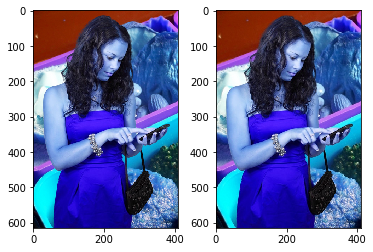

In [17]:
comp = composite(cv2.imread('fg1.jpg'), cv2.imread('bg1.jpg'), cv2.imread('alpha1.jpg'))
comp = comp.astype(np.uint8)
plt.figure()
plt.subplot(121)
plt.imshow(comp)
cv2.imwrite('/home/subramanyam.m/temp.jpg', comp)
comp1 = cv2.imread('/home/subramanyam.m/temp.jpg')
plt.subplot(122)
plt.imshow(comp1)
print((comp - comp1).sum()/comp.shape[0]/comp.shape[1])